# BasicDFN2D: simulating in-plane electrolyte flows

PyBaMM's [single-layer pouch cell model](https://docs.pybamm.org/en/latest/source/examples/notebooks/models/pouch-cell-model.html) and `"x-lumped"` [thermal model](https://docs.pybamm.org/en/latest/source/examples/notebooks/models/thermal-models.html) use asymptotic reduction to model the effects of uneven current distribution and thermal gradients with minimal computational complexity. These are the most common types of inhomogeneity within a cell.

However, the asymptotic reduction assumed lithium ions cannot move in the in-plane directions, which means other types of inhomogeneity such as negative electrode overhang and manufacturing defects are not captured. To predict these effects, a full two-dimensional model is required. The `BasicDFN` class can be used for this.

In these example, we use the `BasicDFN` class to reproduce an effect observed by [Liu and Arnold (2020)](https://iopscience.iop.org/article/10.1149/1945-7111/abb838/meta), where placing an artificial blockage in the separator causes localized lithium plating.

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np

Note: you may need to restart the kernel to use updated packages.


Load the `BasicDFN2D` model and add a defect by making the separator porosity a function of `z_s`. Like all `FunctionParameter` objects, all arguments (in this case, `x_s` and `z_s`) must be listed when defining the function, even if there is no dependence on them.

In [2]:
model = pybamm.lithium_ion.BasicDFN2D()
param = pybamm.ParameterValues("Ecker2015")
Lz = param["Electrode height [m]"]
exp = pybamm.Experiment(
    ["Discharge at 1C until 2.7 V", "Charge at 0.8C until 4.2 V", "Hold at 4.2 V until C/20"]
)


def _sigmoid(arg):
    return (1 + np.tanh(arg)) / 2


def _top_hat(arg, a, b, k=200):
    return _sigmoid(k * (arg - a)) * _sigmoid(k * (b - arg))


def eps_sep(x_s, z_s):
    return 0.508 - 0.458 * (
        _top_hat(arg=z_s, a=Lz*0.4, b=Lz*0.6)
    )


param_defect = param.copy()
param_defect.update({"Separator porosity": eps_sep})

Solve and plot. Notice how the lithium ions in the electrolyte have to move around the blockage, just like a fluid would.

In [3]:
sim_defect = pybamm.Simulation(model, parameter_values=param_defect, experiment=exp)
sol_defect = sim_defect.solve()
output_variables = [
    "Negative electrode surface potential difference [V]",
    "Negative electrode surface stoichiometry",
    "Negative electrode ocp [V]",
    "Electrolyte flux X-component [mol.m-2.s-1]",
    "Electrolyte flux Z-component [mol.m-2.s-1]",
    "Voltage [V]",
]
plot_defect = sol_defect.plot(output_variables, variable_limits="tight", shading="auto")

interactive(children=(FloatSlider(value=0.0, description='t', max=2.5547234530658605, step=0.02554723453065860…

There is no lithium plating in this model. However, at the end of the constant current charge, the negative electrode potential difference in the area near the defect goes below 0 and the surface stoichiometry becomes 1, which are the two conditions required for lithium plating to happen.

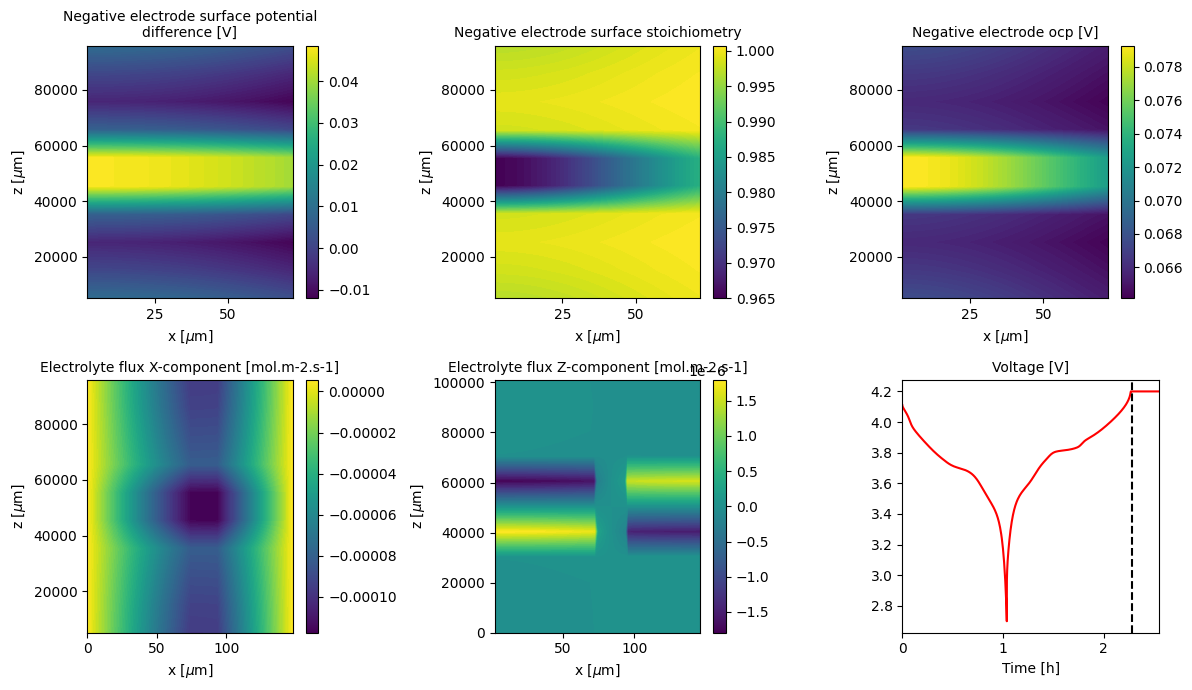

In [4]:
plot_defect.plot(2.285)

Would this have happened without the blockage? To find out, run the model again with the original `param` dictionary that doesn't have altered separator porosity.

In [5]:
sim_pristine = pybamm.Simulation(model, parameter_values=param, experiment=exp)
sol_pristine = sim_pristine.solve()
output_variables = [
    "Negative electrode surface potential difference [V]",
    "Negative electrode surface stoichiometry",
    "Negative electrode ocp [V]",
    "Electrolyte flux X-component [mol.m-2.s-1]",
    "Electrolyte flux Z-component [mol.m-2.s-1]",
    "Voltage [V]",
]
plot_pristine = sol_pristine.plot(output_variables, variable_limits="tight", shading="auto")

interactive(children=(FloatSlider(value=0.0, description='t', max=2.5714322890271, step=0.025714322890271), Ou…

Without the defect, the negative electrode potential difference does not go below zero at any point.

In [6]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Madeleine Ecker, Stefan Käbitz, Izaro Laresgoiti, and Dirk Uwe Sauer. Parameterization of a Physico-Chemical Model of a Lithium-Ion Battery: II. Model Validation. Journal of The Electrochemical Society, 162(9):A1849–A1857, 2015. doi:10.1149/2.0541509jes.
[3] Madeleine Ecker, Thi Kim Dung Tran, Philipp Dechent, Stefan Käbitz, Alexander Warnecke, and Dirk Uwe Sauer. Parameterization of a Physico-Chemical Model of a Lithium-Ion Battery: I. Determination of Parameters. Journal of the Electrochemical Society, 162(9):A1836–A1848, 2015. doi:10.1149/2.0551509jes.
[4] Alastair Hales, Laura Bravo Diaz, Mohamed Waseem Marzook, Yan Zhao, Yatish Patel, and Gregory Offer. The cell cooling coefficient: a standard to define heat rejection from lithi